### Imports

In [1]:
import os
import pandas as pd
import numpy as np
import torch
import lightning as L
import lightning.pytorch as pl

### Load sequence data from cryptic seq experiment

In [10]:
# Preprosses cryptic seq data to normalize by on target
import utils.cs_excel_data

# Flag to trigger data export from excel files
export_excel_data = False

cs_data_file = 'data/TB000208a.outputs.xlsx'
data_path = 'data/Tb000208a'
train_sheets = ['GT-Rep1-N7_S1','GT-Rep2-N7_S2','GT-Rep3-N7_S3']
test_sheets = ['Pool-Rep1-N7_S4','Pool-Rep2-N7_S5','Pool-Rep3-N7_S6']

if export_excel_data:
    utils.cs_excel_data.extract_excel_cs_data(cs_data_file, train_sheets, data_path, 'fit.csv')
    utils.cs_excel_data.extract_excel_cs_data(cs_data_file, test_sheets, data_path, 'test.csv')

In [15]:
from lightning.pytorch.utilities.types import EVAL_DATALOADERS
from models import mlp
from datasets import one_hot

bins = 2
seq_length = 22
vocab_size = 5
input_size = seq_length*vocab_size
hidden_size = 1024
n_hidden = 2
train_test_split = 0.8

class CSDataModule(L.LightningDataModule):
    def __init__(self, data_path, batch_size):
        super().__init__()
        self.data_path = data_path
        self.batch_size = batch_size

    def setup(self, stage: str):
        # Select test/train dataset
        fname = stage + '.csv'

        # Load the cryptic seq data
        sites = pd.read_csv(os.path.join(self.data_path, fname))

        # Log transform the data and bin into N bins
        sites['norm_count'] = np.log(sites['norm_count'])
        sites['bin'] = pd.cut(sites['norm_count'], bins, labels=False)

        # Compute class frequencies for weighting
        class_sample_count = np.array([len(np.where(sites['bin'] == c)[0]) for c in np.unique(sites['bin'])])

        # Cryptic sites data for training
        sequences = sites['seq'].values
        labels = sites['bin'].values
        self.seq_length = len(sequences[0])
        self.dataset = one_hot.Dataset(sequences, labels, vocab_size=vocab_size, output_size=bins)

        # Sample weights based on label and class frequency
        weight = 1. / class_sample_count
        samples_weight = np.array([weight[t] for t in labels])
        self.samples_weight = torch.from_numpy(samples_weight)

        if stage == 'fit':
            # Test and train data split
            train_size = int(train_test_split*len(self.dataset))
            test_size = len(self.dataset) - train_size
            self.train_dataset, self.val_dataset = torch.utils.data.random_split(self.dataset, [train_size, test_size])

            # Weighted random sampler for upsampling minority class for training
            train_sample_weights = samples_weight[self.train_dataset.indices]
            self.train_sampler = torch.utils.data.WeightedRandomSampler(train_sample_weights, len(train_sample_weights), replacement=True)

        elif stage == 'test':
            self.test_dataset = self.dataset

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, batch_size=self.batch_size, sampler=self.train_sampler)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_dataset, batch_size=self.batch_size)
    
    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_dataset, batch_size=self.batch_size)

data_module = CSDataModule(data_path, batch_size=32)

# Build model
model = mlp.Model(input_size=input_size, hidden_size=hidden_size, output_size=bins, n_hidden=n_hidden, dropout=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Training

In [16]:
# define the LightningModule
class LitClassifier(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.loss_fn = torch.nn.BCEWithLogitsLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        # Model pass
        data, target = batch
        output = self(data)
        loss = self.loss_fn(output, target.float())

        # Logging to TensorBoard (if installed) by default
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        # Model pass
        data, target = batch
        output = self.model(data)
        loss = self.loss_fn(output, target.float())

        # Logging to TensorBoard (if installed) by default
        self.log("val_loss", loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        # Model pass
        data, target = batch
        output = self.model(data)
        loss = self.loss_fn(output, target.float())

        # Logging to TensorBoard (if installed) by default
        self.log("test_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
# init the autoencoder
lit_model = LitClassifier(model)

# train the model
tb_logger = pl.loggers.TensorBoardLogger(save_dir="lightning_logs/")
trainer = pl.Trainer(max_epochs=5, logger=tb_logger, accelerator="gpu")
trainer.fit(lit_model, data_module)
trainer.test(lit_model, data_module)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type              | Params
----------------------------------------------
0 | model   | Model             | 1.2 M 
1 | loss_fn | BCEWithLogitsLoss | 0     
----------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.661     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/matthewbakalar/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/matthewbakalar/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
/Users/matthewbakalar/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3728824555873871
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.3728824555873871}]

### Analysis

In [49]:
from matplotlib import pyplot as plt

# Iterate over the DataLoader and make predictions
val_inputs = []
val_targets = []
val_preds = []
with torch.no_grad():
    for i, (data, target) in enumerate(val_dataloader):
        output = model(data)

        # Convert output probabilities to predicted class
        preds = output.float()

        # Save prediction data
        val_inputs.extend(data.tolist())
        val_preds.extend(preds)
        val_targets.extend(target)

# Translate inputs
trans_dict = {0:'A',1:'T',2:'C',3:'G',4:'N'}
translate_func = lambda x: ''.join([trans_dict[y] for y in x])

inputs = np.argmax(val_inputs, axis=2)
inputs = [translate_func(x) for x in inputs]

# Argmax targets and predictions
val_targets = torch.argmax(torch.stack(val_targets), 1)
val_preds = torch.argmax(torch.stack(val_preds), 1)

predictions = pd.DataFrame({"seq":inputs, "targets":val_targets, "outputs": val_preds})

array([[<Axes: title={'center': 'targets'}>,
        <Axes: title={'center': 'outputs'}>]], dtype=object)

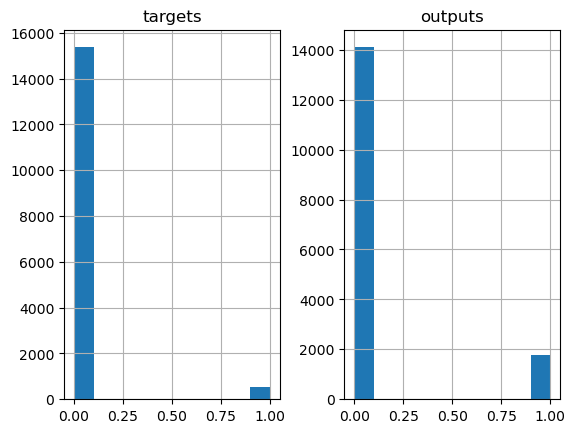

In [50]:
predictions.hist()

In [ ]:
for seq in predictions[predictions['targets'] == 0]['seq']:
    print(seq)

### Validation

In [54]:
# Parameters
BINS = 2
SEQUENCE = 'seq'
VALUE = 'count'

# Load data from cryptic seq experiment
sites_xl = pd.ExcelFile('./data/TB000208a.outputs.xlsx')
sites_xl.sheet_names
training_sheets = ['Pool-Rep1-N7_S4','Pool-Rep2-N7_S5','Pool-Rep3-N7_S6']
sheets = []
for name in training_sheets:
    sheets.append(sites_xl.parse(name))
sites = pd.concat(sheets).reset_index()

# Only take canonical dinucleotide insertions
sites = sites[sites['genome_dinucleotide'] == sites['donor'].str.slice(5,7)]

# Average count at identical sites
sites = sites.groupby(['seq'], as_index=False).sum(numeric_only=False)

# Noramlize by on target count
UMI_norm_factor = sites[sites['chrom'].str.contains('PL312')]['count'].mean()
sites['count'] = sites['count']/UMI_norm_factor

In [59]:
# Prepare data for classifier
sites[VALUE] = np.log(sites[VALUE])

# Bin the counts into N bins
sites[VALUE], bins = pd.cut(sites[VALUE], BINS, labels=False, retbins=True)

# Compute class frequencies for weighting
class_sample_count = np.array([len(np.where(sites[VALUE] == c)[0]) for c in np.unique(sites[VALUE])])